# Substack Article Text Analysis
Here we analyze substack article text from various blogs to identify characteristics associated with engagement. We also perform unsupervised topic modeling on the text using Latent Dirichlet Allocation (LDA) to identify if there are certain topics more stongly associated with engagement.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from gensim.models import Phrases
import gensim.corpora as corpora
from gensim.models import LdaModel
from ast import literal_eval
from scipy.stats import pearsonr

### Identifying Variables Associated with Engagement

In [8]:
# Connect to the SQLite database
conn = sqlite3.connect('substack_database.db')

# Query to select rows where tokens is not null
query = '''
    SELECT *
    FROM article_data
    WHERE tokens IS NOT NULL
'''

# Load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

In [20]:
# test if variables are significantly associated with reactions and comments (a surrogate for views)

x_variables = [
    'wordcount',
    'polarity',
    'objectivity',
    'number_of_questions',
    'fk_grade_level',
    'gunning_fog_index',
    'reading_time',
    'p_elem_counts',
    'a_elem_counts',
    'img_elem_counts',
    'ul_elem_counts',
    'li_elem_counts',
    'video_elem_counts',
    'br_elem_counts',
]

coefficients = []
p_values = []

for x_variable in x_variables:
    # Calculate the Pearson correlation coefficient and p-value
    correlation_coefficient, p_value = stats.pearsonr(df['comment_count'] + df['reaction_count'], df[x_variable])
    coefficients.append(correlation_coefficient)
    p_values.append(p_value)

stats_df = pd.DataFrame()
stats_df['variable'] = x_variables
stats_df['coefficient'] = coefficients
stats_df['p_value'] = [round(x, 4) for x in p_values]
stats_df

,variable,coefficient,p_value
0,wordcount,-0.096304,0.0012
1,polarity,-0.145529,0.0000
2,objectivity,-0.050706,0.0896
3,number_of_questions,-0.048676,0.1032
4,fk_grade_level,-0.138023,0.0000
5,gunning_fog_index,-0.181597,0.0000
6,reading_time,-0.101503,0.0007
7,p_elem_counts,0.090353,0.0025
8,a_elem_counts,-0.131413,0.0000
9,img_elem_counts,-0.048710,0.1029


In [19]:
# remove non-significant values, interpret results....
stats_df[stats_df.p_value < 0.05].sort_values(by="coefficient")

,variable,coefficient,p_value
5,gunning_fog_index,-0.181597,0.0000
13,br_elem_counts,-0.148797,0.0000
1,polarity,-0.145529,0.0000
4,fk_grade_level,-0.138023,0.0000
8,a_elem_counts,-0.131413,0.0000
11,li_elem_counts,-0.109198,0.0002
6,reading_time,-0.101503,0.0007
0,wordcount,-0.096304,0.0012
10,ul_elem_counts,-0.071684,0.0163
7,p_elem_counts,0.090353,0.0025


Interpretation:
- Overall it seems that shorter articles (ower reading time, elements, shorter wordcount) with higher readability (lower gunning fog index, lower Flesch-Kincaid readability levels) have more viewership
- More negative articles are associated with more viewership and engagement (polarity), thats a bit dark....

<AxesSubplot:xlabel='fk_grade_level', ylabel='total_engagement'>

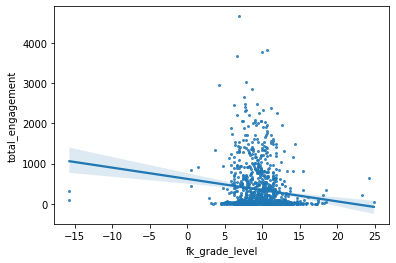

In [37]:
df["total_engagement"] = df['comment_count'] + df['reaction_count']

sns.regplot(data=df, x="fk_grade_level", y="total_engagement", scatter_kws={'s': 4})

In [43]:
# get the source for each article (blog)
blog_urls = []
for url in df['canonical_url']:
    domain_parts = url.split('.com')
    if len(domain_parts) > 0:
        blog_urls.append(domain_parts[0] + ".com")
    else:
        blog_urls.append(None)

df['blog_url'] = blog_urls
len(set(blog_urls)) # 44 unique blogs

44

In [42]:
# im guessing that the blog source has a bigger contribution than the other variables...it is.

# Assuming 'total_engagement' is your dependent variable (y)
y = df['total_engagement']

# Selecting independent variables (X)
X = df[['blog_url', 'wordcount', 'polarity', 'objectivity', 'number_of_questions',
        'fk_grade_level', 'gunning_fog_index', 'reading_time', 'p_elem_counts',
        'a_elem_counts', 'img_elem_counts', 'ul_elem_counts', 'li_elem_counts',
        'video_elem_counts', 'br_elem_counts']]

# Encoding the categorical variable 'blog_url'
X['blog_url'] = pd.Categorical(X['blog_url'])
X = pd.get_dummies(X, columns=['blog_url'], drop_first=True)

# Adding a constant term (intercept) to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get a summary of the model
summary = model.summary()

print(summary)


                            OLS Regression Results                            
Dep. Variable:       total_engagement   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     27.60
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          4.31e-170
Time:                        18:57:59   Log-Likelihood:                -8196.9
No. Observations:                1122   AIC:                         1.651e+04
Df Residuals:                    1064   BIC:                         1.680e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                                                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

/opt/anaconda3/envs/datasci7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Topic Modeling with LDA

In [54]:
documents = [literal_eval(tokens) for tokens in df['tokens']] # convert the strings to proper lists
documents = [[token for token in document if len(token) > 2] for document in documents] # remove any tokens that are one, two characters or empty characters

# Add n-grams to docs (only ones that appear 50 times or more).
bigrams = Phrases(documents, min_count=50)
for x in range(len(documents)):
    for token in bigrams[documents[x]]:
        if '_' in token:
            # Token is a bigram, add to document.
            documents[x].append(token)

dictionary = corpora.Dictionary(documents)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus = [dictionary.doc2bow(document) for document in documents]

In [73]:
# Create the LDA model

num_topics = 5  
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

# Print the topics and their top words
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.013*"beauty" + 0.010*"think" + 0.007*"political" + 0.006*"thats" + 0.006*"really"')
(1, '0.007*"covid" + 0.005*"market" + 0.005*"may" + 0.005*"last" + 0.004*"power"')
(2, '0.007*"trump" + 0.005*"back" + 0.005*"said" + 0.005*"know" + 0.005*"never"')
(3, '0.008*"news" + 0.007*"media" + 0.007*"said" + 0.006*"colorado" + 0.006*"china"')
(4, '0.009*"music" + 0.009*"book" + 0.005*"thats" + 0.004*"never" + 0.004*"life"')


In [74]:
# Assign a topic to each article

# Create a list to store the topic assignments for each document
document_topics = []

# Infer topic distributions for each document
for doc_bow in corpus:
    # Get the topic distribution for the document
    doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    
    # Sort the topics by probability in descending order
    doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    
    # Get the most probable topic (the first topic in the sorted list)
    most_probable_topic = doc_topics[0]
    
    # Append the topic ID to the list of document topics
    document_topics.append(most_probable_topic[0])

# Add the document topics as a new column in your DataFrame
df['topic'] = document_topics

# Define a mapping from numbers to labels, create some names based on the top 5 words
topic_mapping = {
    0: "Beauty and Self-Image",
    1: "COVID-19 and Market Trends",
    2: "Political Commentary and Opinions",
    3: "News, Media, and Global Affairs",
    4: "Music, Literature, and Artistic Expression"
}

# Use the 'replace' method to map the numbers with labels
df['topic_name'] = df['topic'].replace(topic_mapping)


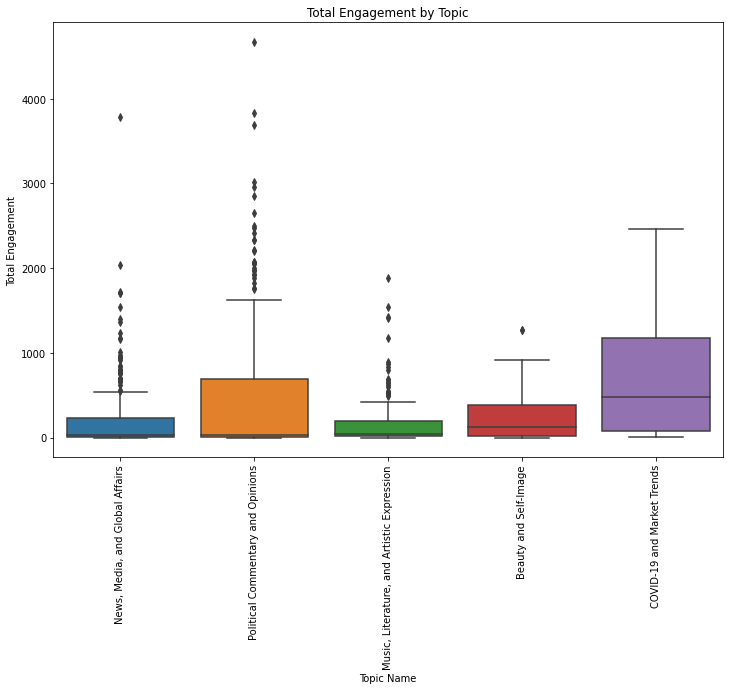

In [81]:
# Are any of the topics associated with significantly higher total engagement than the others?

# Visualize the topics against one another....

plt.figure(figsize=(12, 8))  
sns.boxplot(x='topic_name', y='total_engagement', data=df)

# Set labels and title
plt.xlabel('Topic Name')
plt.ylabel('Total Engagement')
plt.title('Total Engagement by Topic')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [82]:
# Run an ANOVA with a Tukey HSD to determine if any are significantly greater
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Fit the ANOVA model
model = ols('total_engagement ~ topic_name', data=df).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table to check for significance
print("ANOVA Table:\n", anova_table)

# Perform the Tukey post-hoc test
tukey_result = pairwise_tukeyhsd(df['total_engagement'], df['topic_name'])

# Print the Tukey test summary
print("\nTukey Post-Hoc Test:\n", tukey_result)


ANOVA Table:
                   sum_sq      df          F        PR(>F)
topic_name  3.296376e+07     4.0  28.072627  3.032393e-22
Residual    3.279041e+08  1117.0        NaN           NaN

Tukey Post-Hoc Test:
                                       Multiple Comparison of Means - Tukey HSD, FWER=0.05                                       
                  group1                                     group2                    meandiff p-adj    lower    upper   reject
--------------------------------------------------------------------------------------------------------------------------------
                     Beauty and Self-Image                 COVID-19 and Market Trends  409.1099    0.0  249.3404 568.8793   True
                     Beauty and Self-Image Music, Literature, and Artistic Expression  -64.4731  0.802 -223.3518  94.4056  False
                     Beauty and Self-Image            News, Media, and Global Affairs  -16.3566 0.9983 -166.4602  133.747  False
               

In [ ]:
# Beauty and Self Image > Music, Literature, and Artistic Expression
# Beauty and Self Image > News, Media, and Global Affairs 
# Music, Literature, and Artistic Expression > News, Media, and Global Affairs

In [88]:
# alternately, try to look at the pearson correlation 

# Calculate Pearson correlation for each unique topic_name
correlation_data = []
unique_topics = df['topic_name'].unique()

for topic in unique_topics:
    df['has_topic'] = (df['topic_name'] == topic).astype(int)
    coefficient, p_value = pearsonr(df['total_engagement'], df['has_topic'])
    correlation_data.append([topic, coefficient, round(p_value, 4)])

# Create a DataFrame from the correlation data
correlation_df = pd.DataFrame(correlation_data, columns=['topic_name', 'coefficient', 'p_value'])

correlation_df


,topic_name,coefficient,p_value
0,"News, Media, and Global Affairs",-0.128834,0.0000
1,Political Commentary and Opinions,0.110036,0.0002
2,"Music, Literature, and Artistic Expression",-0.147240,0.0000
3,Beauty and Self-Image,-0.081136,0.0065
4,COVID-19 and Market Trends,0.236822,0.0000
